# Comparison of Classifiers

### Libraries

The following libraries will be used in the notebook:
* caret - for training and testing various types of models
* ggplot - used for plotting data / results
* glmnet - required for building penalized (or unplenalized) regression and classification models
* e1071 - required library for building support vector machines
* MASS - required library for Linear Discriminant Analysis
* h2o - Java based library for deep learning (h2o included a lot of other useful functionality that we will not using in this notebook).
* MICE - used for missing variable imputation
* MissForest - used for missing variable imputation


In [2]:
#install.packages("caret")
#install.packages("ggplot2")
#install.packages("glmnet")
#install.packages("e1071")
#install.packages("h2o")
#install.packages("kernlab")
#install.packages("missForest")
#install.packages("mice")
library(caret)
library(ggplot2)
library(glmnet)
library(e1071)
library(MASS)
library(kernlab)
library(missForest)
library(mice)
library(h2o)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13


Attaching package: ‘kernlab’

The following object is masked from ‘package:ggplot2’:

    alpha

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: itertools
Loading required package: iterators

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    c

### Introduction
In this notebook we will ultimately be developing a predictive classifier for the diagnosis of prostate cancer. Prior to building the classifier we will explore the data and prepare it for modelling, imputing any missing values as needed. All we have been told about the data is that has been generated in some way.

### Data Exploration
We will begin by loading the data into the notebook and looking at the number of features present using the str function.

In [3]:
# load data from url or local drive
data <- read.csv(url("https://drive.google.com/uc?export=download&id=0B9lPq9swUtlwUW9YWHU3aHR2bWc"))

str(data)

'data.frame':	3000 obs. of  12 variables:
 $ ID    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ ATT1  : Factor w/ 11 levels "?","1","10","2",..: 2 1 3 5 5 4 2 10 4 2 ...
 $ ATT2  : int  4 8 7 4 5 7 1 5 9 1 ...
 $ ATT3  : Factor w/ 11 levels "?","1","10","2",..: 2 11 1 5 4 5 5 4 4 2 ...
 $ ATT4  : Factor w/ 11 levels "?","1","10","2",..: 6 2 9 1 2 4 7 8 2 10 ...
 $ ATT5  : Factor w/ 11 levels "?","1","10","2",..: 5 2 1 4 8 2 11 4 6 11 ...
 $ ATT6  : int  7 1 5 8 5 4 3 7 6 2 ...
 $ ATT7  : int  1 1 2 4 3 10 7 3 8 2 ...
 $ ATT8  : int  2 5 7 6 1 3 1 6 8 5 ...
 $ ATT9  : int  6 6 1 7 7 9 10 7 4 1 ...
 $ ATT10 : int  8 1 1 2 1 5 7 3 3 3 ...
 $ Result: int  0 1 2 1 0 1 1 1 1 0 ...


We can see there are 12 variables in the data. When loading data from a csv file R will attempt to convert the data (all originally stored as strings) to a suitable data type. Seven of the twelve variables in the data have been converted to integers while four have been converted to factors meaning there are more than just integers or numbers present in these columns. We can see already that there is a factor level of "?" in these columns. We know from the assignment description that all of the preidctive features should be integers between 1 and 10 so we can assume "?" and any other non-numerical values represent missing or incorrect data. 

Let's take a look at the head of the data frame.

In [4]:
head(data)

ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,4,1,4,3,7,1,2,6,8,0
2,?,8,9,1,1,1,1,5,6,1,1
3,10,7,?,7,?,5,2,7,1,1,2
4,3,4,3,?,2,8,4,6,7,2,1
5,3,5,2,1,6,5,3,1,7,1,0
6,2,7,3,2,1,4,10,3,9,5,1


Even just from the head of the table we can see "?" present in ATT1, ATT3, ATT4 and ATT5. Let's force the entire data frame into numeric values. We'll need to nest the function and first turn the factors back into character variables before converting to numerical values. This will produce warnings as we will be coercing NA by forcing non-numerical values ("?") into numerical values. This is by design and we can then use R functions specific to NA values.

In [5]:
data <- lapply(data, function(x) as.numeric(as.character(x)))
data <- as.data.frame(data)
head(data)

Warning message in as.numeric(as.character(x)):
“NAs introduced by coercion”Warning message in as.numeric(as.character(x)):
“NAs introduced by coercion”Warning message in as.numeric(as.character(x)):
“NAs introduced by coercion”Warning message in as.numeric(as.character(x)):
“NAs introduced by coercion”

ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,4,1,4,3,7,1,2,6,8,0
2,NA,8,9,1,1,1,1,5,6,1,1
3,10,7,NA,7,NA,5,2,7,1,1,2
4,3,4,3,NA,2,8,4,6,7,2,1
5,3,5,2,1,6,5,3,1,7,1,0
6,2,7,3,2,1,4,10,3,9,5,1


Great we can see from the head of the table that the "?" values have been converted to NA values and all other values are unchanged in appearance, they are now of course integer types which we can confirm by calling the str function again.

In [6]:
str(data)

'data.frame':	3000 obs. of  12 variables:
 $ ID    : num  1 2 3 4 5 6 7 8 9 10 ...
 $ ATT1  : num  1 NA 10 3 3 2 1 8 2 1 ...
 $ ATT2  : num  4 8 7 4 5 7 1 5 9 1 ...
 $ ATT3  : num  1 9 NA 3 2 3 3 2 2 1 ...
 $ ATT4  : num  4 1 7 NA 1 2 5 6 1 8 ...
 $ ATT5  : num  3 1 NA 2 6 1 9 2 4 9 ...
 $ ATT6  : num  7 1 5 8 5 4 3 7 6 2 ...
 $ ATT7  : num  1 1 2 4 3 10 7 3 8 2 ...
 $ ATT8  : num  2 5 7 6 1 3 1 6 8 5 ...
 $ ATT9  : num  6 6 1 7 7 9 10 7 4 1 ...
 $ ATT10 : num  8 1 1 2 1 5 7 3 3 3 ...
 $ Result: num  0 1 2 1 0 1 1 1 1 0 ...


We also know from the assignment description that the Result (target feature) is actually a factor so we will convert this to a factor.

In [7]:
data$Result <- factor(data$Result)
head(data)

ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,4,1,4,3,7,1,2,6,8,0
2,NA,8,9,1,1,1,1,5,6,1,1
3,10,7,NA,7,NA,5,2,7,1,1,2
4,3,4,3,NA,2,8,4,6,7,2,1
5,3,5,2,1,6,5,3,1,7,1,0
6,2,7,3,2,1,4,10,3,9,5,1


Now that we have replaced any non-integer values in the predictor features of the data frame with NAs we can use the R is.na function to identify any rows that have NA values in them.
which(is.na(data), arr.ind=TRUE) will return an array with the row and column indexes of the entries in the data frame that have NA values in them. Since we only want the rows we'll take the first entry in the array and use it to select the rows out of the data.

In [8]:
data[which(is.na(data), arr.ind=TRUE)[,1],]

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
2,2,NA,8,9,1,1,1,1,5,6,1,1
3,3,10,7,NA,7,NA,5,2,7,1,1,2
4,4,3,4,3,NA,2,8,4,6,7,2,1
3.1,3,10,7,NA,7,NA,5,2,7,1,1,2


This has returned row 2, 3, 4 and 3 again (shown as 3.1 due to appearing a second time). Somewhat suprisingly the missing values were all visible in the head of the table!

Since we are talking about only three rows in a 300 entry table it would normally be asvisable to delete the rows rather than impute the values however we have specifically been tasked with imputing any missing values so for now we will put them aside and continue with the data exploration by first building a data frame that inlcudes only the complete entries.

In [9]:
completeData <- data[-which(is.na(data), arr.ind=TRUE)[,1], ]
head(completeData)

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,1,4,1,4,3,7,1,2,6,8,0
5,5,3,5,2,1,6,5,3,1,7,1,0
6,6,2,7,3,2,1,4,10,3,9,5,1
7,7,1,1,3,5,9,3,7,1,10,7,1
8,8,8,5,2,6,2,7,3,6,7,3,1
9,9,2,9,2,1,4,6,8,8,4,3,1


We also know that the first attribute in the data frame is ID which is not to be used as a predictor so we can drop that from the data frame and take a look at the summary of the remaining data.

In [10]:
completeData <- completeData[-1]
head(completeData)

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,4,1,4,3,7,1,2,6,8,0
5,3,5,2,1,6,5,3,1,7,1,0
6,2,7,3,2,1,4,10,3,9,5,1
7,1,1,3,5,9,3,7,1,10,7,1
8,8,5,2,6,2,7,3,6,7,3,1
9,2,9,2,1,4,6,8,8,4,3,1


Finally let's check the sumamry of the data to makes sure everything is as expected.

In [11]:
summary(completeData)

      ATT1             ATT2             ATT3             ATT4      
 Min.   : 1.000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.00  
 1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.00  
 Median : 4.000   Median : 4.000   Median : 4.000   Median : 4.00  
 Mean   : 4.423   Mean   : 4.499   Mean   : 4.421   Mean   : 4.44  
 3rd Qu.: 7.000   3rd Qu.: 7.000   3rd Qu.: 7.000   3rd Qu.: 6.00  
 Max.   :10.000   Max.   :10.000   Max.   :10.000   Max.   :10.00  
      ATT5             ATT6             ATT7             ATT8       
 Min.   : 1.000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.000  
 1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000  
 Median : 4.000   Median : 4.000   Median : 4.000   Median : 4.000  
 Mean   : 4.328   Mean   : 4.431   Mean   : 4.481   Mean   : 4.476  
 3rd Qu.: 6.000   3rd Qu.: 6.000   3rd Qu.: 7.000   3rd Qu.: 7.000  
 Max.   :10.000   Max.   :10.000   Max.   :10.000   Max.   :10.000  
      ATT9            ATT10        Result

We can see that all the values of the predictor features range from 1 to 10, as described in the assignment and the Result is now a factor that is inbalaned towards 0 and 1 (corresponding with "curable" and "tumour stage").

### Data Visualisation

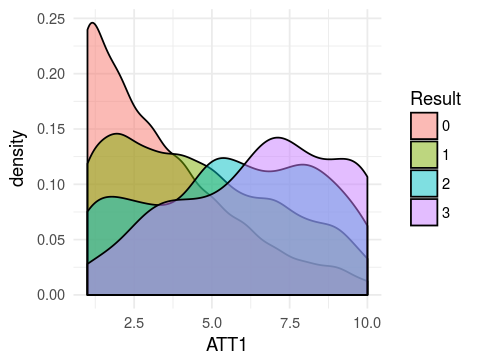

In [12]:
options(repr.plot.width=4, repr.plot.height=3)
ggplot(completeData, aes(x=ATT1, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

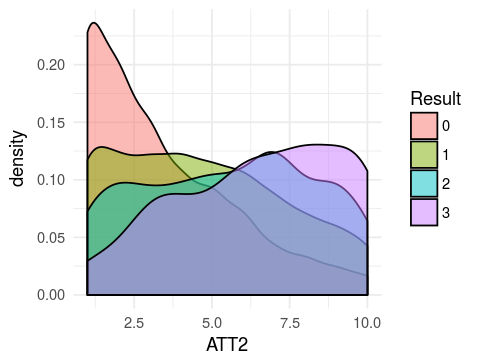

In [13]:
ggplot(completeData, aes(x=ATT2, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

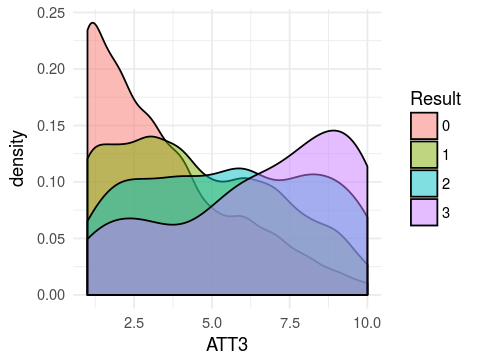

In [14]:
ggplot(completeData, aes(x=ATT3, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

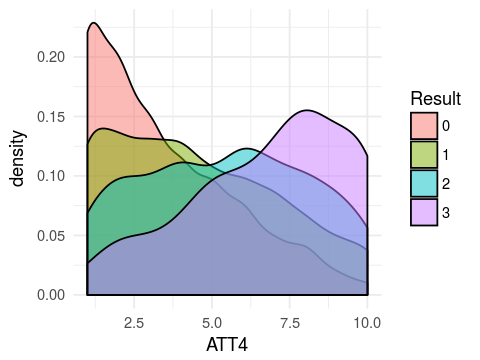

In [15]:
ggplot(completeData, aes(x=ATT4, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

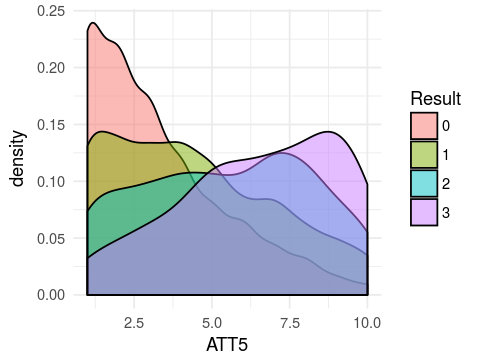

In [16]:
ggplot(completeData, aes(x=ATT5, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

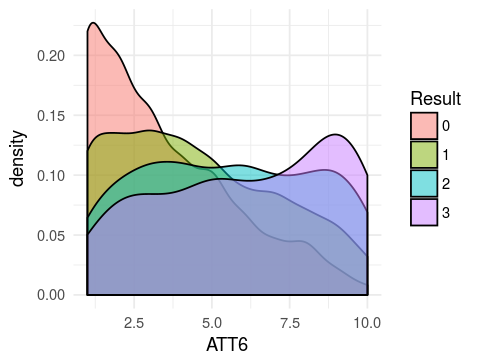

In [17]:
ggplot(completeData, aes(x=ATT6, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

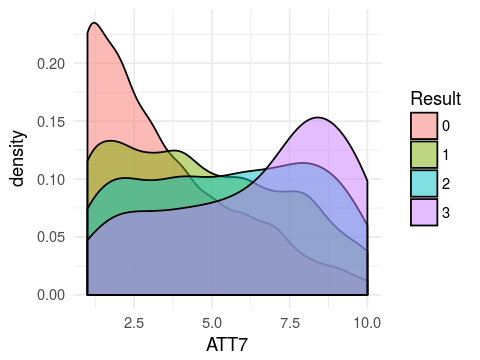

In [18]:
ggplot(completeData, aes(x=ATT7, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

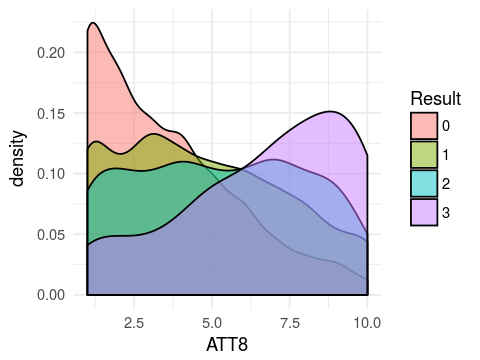

In [19]:
ggplot(completeData, aes(x=ATT8, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

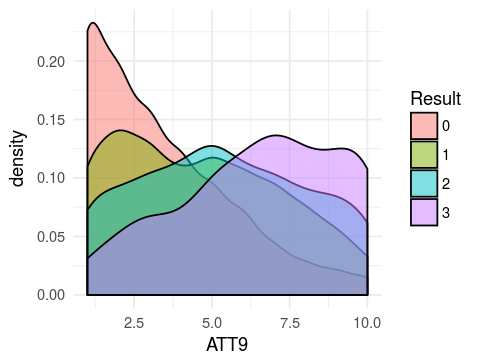

In [20]:
ggplot(completeData, aes(x=ATT9, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

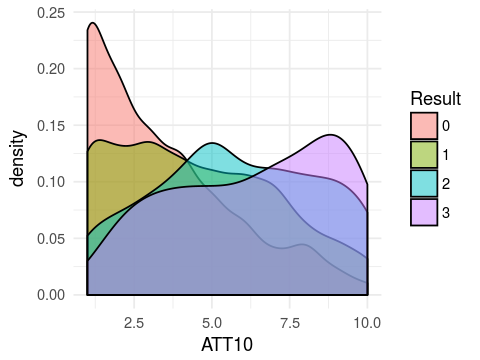

In [21]:
ggplot(completeData, aes(x=ATT10, fill=Result)) + geom_density(alpha = 0.5) + theme_minimal()

Interestingly all of these plots show a very similar distribution. Low values of all attributes are likely to lead to class 0 while high values will likely lead to class 3. Class 1 and 2 are more subtle but again it is evident that there are more class 1 toward the lower attribute values.

What is also clear is that the variable distribution by class (for all variables) does not follow a normal distribution.

### Missing Data Imputation

The above density plots suggest that imputing by using the class mean or any other method that relies on a normal distribution of the features will not produced good result. We will look at the imputation values predicted by the MICE and MissForest packages. 

<b>Imputation using MICE</b><br>
MICE will use predicitve mean matching to try and find a set of observed values that closely match the predicted mean of the missing value and randomly select from that set.

<b>Imputation using MissForest</b><br>
The MissForest package 

In [22]:
attributeList <- c('ATT1', 'ATT3', 'ATT4', 'ATT5')

checkImputation <- function(data, attributeList, K) {
    svmGrid <- expand.grid(C = c(0.75, 1, 1.5, 2, 5, 10))
    trCtrl <- trainControl(method = "cv", number = 10)


    
    rmseDataFrame <-  data.frame(matrix(, nrow=0, ncol=4))
    colnames(rmseDataFrame) <- c('Attribute', 'MissForest', 'MICE', 'SVM')
    rmseMF <- 0
    rmseMICE <- 0
    i <- 1
    for (attribute in attributeList){
        imputationData <- data
        rmseDataFrame[i, 'Attribute'] <- attribute
        # if the attribute being imputed is ATT3 delete ATT5
        if (attribute == 'ATT3') {
            imputationData <- subset(imputationData, select=-c(ATT5))
        }
        # if the attribute being imputed is ATT5 delete ATT3
        if (attribute == 'ATT5') {
            imputationDatae <- subset(imputationData, select=-c(ATT3))
        }
        
        svmModel <- train(as.formula(paste(attribute, '~ .')) , data = imputationData, preProc = c("center","scale"), method = "svmLinear", trControl=trCtrl, tuneGrid = svmGrid)
        rmseDataFrame[i, 'SVM'] <- min(svmModel$results['RMSE'])
    
        k <- 1
        for (k in 1:K) {
            # get a random set of 50 integers representing random row index of the data
            sampleRowSetNa <- sample(nrow(imputationData),50)
            # in the current attribute we are testing set the random rows from above to NA
            imputationData[attribute][sampleRowSetNa,] <- NA
            # run the imputation using missForest
            imputationData.imputed <- missForest(imputationData)
            rmseMF[k]  <- RMSE(imputationData.imputed$ximp[attribute][sampleRowSetNa,], completeData[attribute][sampleRowSetNa,])
            imputationData.imputed <- mice(imputationData, m=1, maxit = 50, method = 'pmm', seed = 500)
            imputationData.imputed <- complete(imputationData.imputed, 1)
            rmseMICE[k] <- RMSE(imputationData.imputed[attribute][sampleRowSetNa,], completeData[attribute][sampleRowSetNa,])
        }

        rmseDataFrame[i, 'MissForest'] <- mean(rmseMF)
        rmseDataFrame[i, 'MICE'] <- mean(rmseMICE)
             
        i = i + 1

    }
    return(rmseDataFrame)
}
checkImputationRMSE <- checkImputation(completeData, attributeList, 10)

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!

 iter imp variable
  1   1  ATT1
  2   1  ATT1
  3   1  ATT1
  4   1  ATT1
  5   1  ATT1
  6   1  ATT1
  7   1  ATT1
  8   1  ATT1
  9   1  ATT1
  10   1  ATT1
  11   1  ATT1
  12   1  ATT1
  13   1  ATT1
  14   1  ATT1
  15   1  ATT1
  16   1  ATT1
  17   1  ATT1
  18   1  ATT1
  19   1  ATT1
  20   1  ATT1
  21   1  ATT1
  22   1  ATT1
  23   1  ATT1
  24   1  ATT1
  25   1  ATT1
  26   1  ATT1
  27   1  ATT1
  28   1  ATT1
  29   1  ATT1
  30   1  ATT1
  31   1  ATT1
  32   1  ATT1
  33   1  ATT1
  34   1  ATT1
  35   1  ATT1
  36   1  ATT1
  37   1  ATT1
  38   1  ATT1
  39   1  ATT1
  40   1  ATT1
  41   1  ATT1
  42   1  ATT1
  43   1  ATT1
  44   1  ATT1
  45   1  ATT1
  46   1  ATT1
  47   1  ATT1
  48   1  ATT1
  49   1  ATT1
  50   1  ATT1
  missForest i

In [23]:
checkImputationRMSE

Attribute,MissForest,MICE,SVM
ATT1,2.405233,3.236590,2.263700
ATT3,2.360581,3.335541,2.358680
ATT4,2.411209,3.153231,2.271465
ATT5,2.296967,3.124650,2.237270


We can see that for all attributes the SVM regression has performed best. We'll need to build four different models to impute each of the values in the data set.

<b>Model for ATT1</b>
We'll use caret to help build the regression mdoels for the imputation of the missing data. First we need to set up the train control method for cross validation using ten folds, we'll also set up the tuning grid parameters for C, the cost function used.

In [24]:
svmGrid <- expand.grid(C = c(0.05, 0.1, 0.2))
trCtrl <- trainControl(method = "cv", number = 10)
att1Model <- train(ATT1 ~ . , data = completeData, preProc = c("center","scale"), method = "svmLinear", trControl=trCtrl, tuneGrid = svmGrid)
att1Model

Support Vector Machines with Linear Kernel 

2997 samples
  10 predictors

Pre-processing: centered (12), scaled (12) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2697, 2697, 2697, 2699, 2696, 2698, ... 
Resampling results across tuning parameters:

  C     RMSE      Rsquared   MAE     
  0.05  2.258308  0.3139381  1.831731
  0.10  2.260499  0.3136408  1.830265
  0.20  2.261690  0.3139809  1.829431

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was C = 0.05.

<b>Model Performance</b><br>
We can see the model has performed in line with the cross validation found earlier in our model comparison table. Let's now impute and replace the NA value in the data at row 2.

In [25]:
imputedData <- data[-1]
imputedData[2,]

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
2,NA,8,9,1,1,1,1,5,6,1,1


In [26]:
attData <- data[-1]
att1Predict <- round(predict(object = att1Model, newdata = attData[2,]), 0)
att1Predict

2 
7

In [27]:
imputedData[2,1] <- att1Predict
head(imputedData)

ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,4,1,4,3,7,1,2,6,8,0
7,8,9,1,1,1,1,5,6,1,1
10,7,NA,7,NA,5,2,7,1,1,2
3,4,3,NA,2,8,4,6,7,2,1
3,5,2,1,6,5,3,1,7,1,0
2,7,3,2,1,4,10,3,9,5,1


<b>Model for ATT4</b>

In [28]:
att4Model <- train(ATT4 ~ . , data = completeData, preProc = c("center","scale"), method = "svmLinear", trControl=trCtrl, tuneGrid = svmGrid)
att4Model

Support Vector Machines with Linear Kernel 

2997 samples
  10 predictors

Pre-processing: centered (12), scaled (12) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2697, 2698, 2697, 2697, 2698, 2699, ... 
Resampling results across tuning parameters:

  C     RMSE      Rsquared   MAE     
  0.05  2.263310  0.2982758  1.830265
  0.10  2.266542  0.2974523  1.827796
  0.20  2.269529  0.2967890  1.826927

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was C = 0.05.

<b>Model Performance</b><br>
We can see the model has performed in line with the cross validation found earlier in our model comparison table. Let's now impute and replace the NA value in the data at row 4.

In [29]:
imputedData[4,]

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
4,3,4,3,NA,2,8,4,6,7,2,1


In [30]:
att4Predict <- round(predict(object = att4Model, newdata = attData[4,]), 0)
att4Predict

4 
5

In [31]:
imputedData[4,4] <- att4Predict
head(imputedData)

ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,4,1,4,3,7,1,2,6,8,0
7,8,9,1,1,1,1,5,6,1,1
10,7,NA,7,NA,5,2,7,1,1,2
3,4,3,5,2,8,4,6,7,2,1
3,5,2,1,6,5,3,1,7,1,0
2,7,3,2,1,4,10,3,9,5,1


<b>Model for ATT3</b><br>
For ATT3 and ATT5 we need to adjust the data set so the prediction for each is made without the other since they are both missing from row 3.

In [32]:
att3Data <- completeData[-5]
head(att3Data)

,ATT1,ATT2,ATT3,ATT4,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,4,1,4,7,1,2,6,8,0
5,3,5,2,1,5,3,1,7,1,0
6,2,7,3,2,4,10,3,9,5,1
7,1,1,3,5,3,7,1,10,7,1
8,8,5,2,6,7,3,6,7,3,1
9,2,9,2,1,6,8,8,4,3,1


In [33]:
att3Model <- train(ATT3 ~ . , data = att3Data, preProc = c("center","scale"), method = "svmLinear", trControl=trCtrl, tuneGrid = svmGrid)
att3Model

Support Vector Machines with Linear Kernel 

2997 samples
   9 predictors

Pre-processing: centered (11), scaled (11) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2698, 2697, 2697, 2699, 2697, 2697, ... 
Resampling results across tuning parameters:

  C     RMSE      Rsquared   MAE     
  0.05  2.359460  0.2513453  1.934976
  0.10  2.360020  0.2519012  1.933645
  0.20  2.360676  0.2520110  1.933528

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was C = 0.05.

<b>Model Performance</b><br>
We can see the model has performed in line with the cross validation found earlier in our model comparison table. Let's now impute and replace the NA value in the data at row 3.

In [34]:
imputedData[3,]

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
3,10,7,NA,7,NA,5,2,7,1,1,2


In [35]:
att3Predict <- round(predict(object = att3Model, newdata = attData[3,]), 0)
att3Predict

3 
6

In [36]:
imputedData[3,3] <- att3Predict
head(imputedData)

ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,4,1,4,3,7,1,2,6,8,0
7,8,9,1,1,1,1,5,6,1,1
10,7,6,7,NA,5,2,7,1,1,2
3,4,3,5,2,8,4,6,7,2,1
3,5,2,1,6,5,3,1,7,1,0
2,7,3,2,1,4,10,3,9,5,1


<b>Model for ATT5<b>

In [37]:
att5Data <- completeData[-3]
head(att5Data)

,ATT1,ATT2,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,4,4,3,7,1,2,6,8,0
5,3,5,1,6,5,3,1,7,1,0
6,2,7,2,1,4,10,3,9,5,1
7,1,1,5,9,3,7,1,10,7,1
8,8,5,6,2,7,3,6,7,3,1
9,2,9,1,4,6,8,8,4,3,1


In [38]:
att5Model <- train(ATT5 ~ . , data = att5Data, preProc = c("center","scale"), method = "svmLinear", trControl=trCtrl, tuneGrid = svmGrid)
att5Model

Support Vector Machines with Linear Kernel 

2997 samples
   9 predictors

Pre-processing: centered (11), scaled (11) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2699, 2698, 2698, 2696, 2697, 2696, ... 
Resampling results across tuning parameters:

  C     RMSE      Rsquared   MAE     
  0.05  2.315736  0.2543370  1.879088
  0.10  2.315191  0.2553151  1.877305
  0.20  2.315211  0.2557998  1.876478

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was C = 0.1.

<b>Model Performance</b><br>
We can see the model has performed in line with the cross validation found earlier in our model comparison table. Let's now impute and replace the NA value in the data at row 3.

In [39]:
att5Predict <- round(predict(object = att5Model, newdata = attData[3,]), 0)
att5Predict

3 
6

In [40]:
imputedData[3,]

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
3,10,7,6,7,NA,5,2,7,1,1,2


In [41]:
imputedData[3,5] <- att3Predict
head(imputedData)

ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,4,1,4,3,7,1,2,6,8,0
7,8,9,1,1,1,1,5,6,1,1
10,7,6,7,6,5,2,7,1,1,2
3,4,3,5,2,8,4,6,7,2,1
3,5,2,1,6,5,3,1,7,1,0
2,7,3,2,1,4,10,3,9,5,1


#### Review of Imputed Data Frame

In [42]:
summary(imputedData)

      ATT1             ATT2             ATT3             ATT4      
 Min.   : 1.000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.00  
 1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.00  
 Median : 4.000   Median : 4.000   Median : 4.000   Median : 4.00  
 Mean   : 4.426   Mean   : 4.501   Mean   : 4.422   Mean   : 4.44  
 3rd Qu.: 7.000   3rd Qu.: 7.000   3rd Qu.: 7.000   3rd Qu.: 6.00  
 Max.   :10.000   Max.   :10.000   Max.   :10.000   Max.   :10.00  
      ATT5             ATT6             ATT7             ATT8       
 Min.   : 1.000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.000  
 1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000  
 Median : 4.000   Median : 4.000   Median : 4.000   Median : 4.000  
 Mean   : 4.326   Mean   : 4.431   Mean   : 4.479   Mean   : 4.478  
 3rd Qu.: 6.000   3rd Qu.: 6.000   3rd Qu.: 7.000   3rd Qu.: 7.000  
 Max.   :10.000   Max.   :10.000   Max.   :10.000   Max.   :10.000  
      ATT9            ATT10        Result

In [43]:
str(imputedData)

'data.frame':	3000 obs. of  11 variables:
 $ ATT1  : num  1 7 10 3 3 2 1 8 2 1 ...
 $ ATT2  : num  4 8 7 4 5 7 1 5 9 1 ...
 $ ATT3  : num  1 9 6 3 2 3 3 2 2 1 ...
 $ ATT4  : num  4 1 7 5 1 2 5 6 1 8 ...
 $ ATT5  : num  3 1 6 2 6 1 9 2 4 9 ...
 $ ATT6  : num  7 1 5 8 5 4 3 7 6 2 ...
 $ ATT7  : num  1 1 2 4 3 10 7 3 8 2 ...
 $ ATT8  : num  2 5 7 6 1 3 1 6 8 5 ...
 $ ATT9  : num  6 6 1 7 7 9 10 7 4 1 ...
 $ ATT10 : num  8 1 1 2 1 5 7 3 3 3 ...
 $ Result: Factor w/ 4 levels "0","1","2","3": 1 2 3 2 1 2 2 2 2 1 ...


We now have a complete data frame with 3000 entries and valid integers between one and ten for all predictor variables. Let's move onto building the classifier models.

## Building a Classifier
We we build four classifiers in approximate order of model complexity: <br>
1. Multinomial Logistic Classifier
2. Support Vector Machine Classifer
3. Gradient Boosted Machine Classifer
4. Neural Network Classifier

The classifiers will be built using the data set with imputed values calculated above.

#### Cross Validation
In order to make sure that the models we build will genralize well we will use cross validation to build and test them on various 'folds' of data. The folds function takes a set of data and creates k folds of training and k folds of corresponding testing data and returns it as a list. These will then be accessed to train and test the classifiers we later build.

In [44]:
folds <- function(data, k = 10) {
  #shuffle the data
  dataShuffled <- data[sample(nrow(data)),]
  
  #Create k  folds
  folds <- cut(seq(1,nrow(dataShuffled)),breaks=k,labels=FALSE)
  
  testData <- list()
  trainData <- list()
  
  for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData[[i]] <- dataShuffled[testIndexes, ]
    trainData[[i]] <- dataShuffled[-testIndexes, ]
  }
  
  return(list('training' = trainData, 'testing' = testData))
}


Lets build 10 folds of train and test data from the data set with imputed values to use to build and test our classification models.

In [45]:
imputedDataCV <- folds(imputedData)

### Multinomial Logistic Classification
One of the simplest classification models available is the logistic regression classifier. Logistic regression is a form of linear classification that uses a sigmoid function and a cutoff value when deciding on the class labels, the decision boundary is still linear for any fixed cut off value. In order to build the classifier we will use the glmnet package and set the family of the classifier to multinomial.

The glmnet package requires that the data be provided in a matrix so let's convert the data to a matrix. We will use the first fold of our data for am in depth trial run, looking at the log(lambda) vs misclassification error and the overall model statistics before building and recording the accuracy for all folds of our data.

First let's convert the data to train and test data and labels and then convert the data portions to matrix form.

In [46]:
train <- imputedDataCV$training[[1]]
test <- imputedDataCV$testing[[1]]
train.data = train[, -which(names(imputedData)  == 'Result')]
train.label = train[, 'Result']
test.data = test[, -which(names(imputedData)  == 'Result')]
test.label = test[, 'Result']
train_y <- train.label
test_y <- test.label
train_x <- as.matrix(train.data)
test_x <- as.matrix(test.data)

Now we can use the cv.glmnet function in the glmnet package to use cross validation to predict the best value of lambda. In this example we are doing ridge regression by setting the value of alpha to 0. After the function has run we will plot the results and be able to visualise the best value for lambda and get an idea about potential performance.

In [ ]:
options(repr.plot.width=8, repr.plot.height=6)
options(warn=-1)
ridgeModel <- cv.glmnet(train_x, train_y, family="multinomial", type.measure="class", alpha=1)
plot(ridgeModel)

Wow! Our misclassification rate is zero for low values of lambda. We'll make some predictions using this model on the test data matrix and create a confusion matrix on the results.

In [48]:
ridgeModel.Predictions <- predict(ridgeModel, s = ridgeModel$lambda.min, test_x, type='class')
confusionMatrix(data = ridgeModel.Predictions, reference = test.label)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 109   0   0   0
         1   0 117   0   0
         2   0   0  56   0
         3   0   0   0  18

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9878, 1)
    No Information Rate : 0.39       
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity            1.0000     1.00   1.0000     1.00
Specificity            1.0000     1.00   1.0000     1.00
Pos Pred Value         1.0000     1.00   1.0000     1.00
Neg Pred Value         1.0000     1.00   1.0000     1.00
Prevalence             0.3633     0.39   0.1867     0.06
Detection Rate         0.3633     0.39   0.1867     0.06
Detection Prevalence   0.3633     0.39   0.1867     0.06
Balanced 

<b>Model Performance</b> <br>As suggested by the log(lambda) plot the multinomial classifier using ridge penalization has performed very well and has an accuracy of 100%. It is worth noting that the lambda value used in the model is very low and because of that very little coefficient penalzation would have been performed, we won't bother changing the alpha parameter which uses a mixture of ridge penalization (0) through to LASSO penalization (1).

We'll now loop through all of the folds of our data and report the accuracy of each model built.

In [49]:
accRecord <- 0
k <- 1
for (k in 1:length(imputedDataCV$training)) {
    train <- imputedDataCV$training[[k]]
    test <- imputedDataCV$testing[[k]]
    train.data = train[, -which(names(imputedData)  == 'Result')]
    train.label = train[, 'Result']
    test.data = test[, -which(names(imputedData)  == 'Result')]
    test.label = test[, 'Result']
    train_y <- train.label
    test_y <- test.label
    train_x <- as.matrix(train.data)
    test_x <- as.matrix(test.data)
    ridgeModel <- cv.glmnet(train_x, train_y, family="multinomial", type.measure="class", alpha=1)
    ridgeModel.Predictions <- predict(ridgeModel, s = ridgeModel$lambda.min, test_x, type='class')
    tempCM <- confusionMatrix(data = ridgeModel.Predictions, reference = test.label)
    accRecord[k] <- tempCM$overall[['Accuracy']]
    cat('For fold ', k, ' the Accuracy was ', accRecord[k], 'using a lambda value of ', ridgeModel$lambda.min, '\n')
}
cat('The mean accuracy was  ', mean(accRecord[k]))

For fold  1  the Accuracy was  1 using a lambda value of  6.661119e-05 
For fold  2  the Accuracy was  1 using a lambda value of  0.0001301747 
For fold  3  the Accuracy was  1 using a lambda value of  4.287633e-05 
For fold  4  the Accuracy was  1 using a lambda value of  9.122224e-05 
For fold  5  the Accuracy was  1 using a lambda value of  5.039259e-05 
For fold  6  the Accuracy was  1 using a lambda value of  8.881114e-05 
For fold  7  the Accuracy was  0.9966667 using a lambda value of  0.0001699081 
For fold  8  the Accuracy was  0.9966667 using a lambda value of  0.0004360395 
For fold  9  the Accuracy was  1 using a lambda value of  7.276754e-05 
For fold  10  the Accuracy was  1 using a lambda value of  5.565836e-05 
The mean accuracy was   1

Great results, we can see that we can build a linear model using mutlinomial logistic regression and achieve excellent accuracy. The results suggest that the data is linearly separable, that is the decision boundaries can be drawn using straight lines (or hyper planes in this case of multidimensional space).

Normally we would stop at this point, it is not really possible to get a simpler classification model for this problem nor is it possible to find a model that performs significantly better. Even if other models with similar accuracy were found we would still select the simplest model which would be this logistic classifier. For the sake of exploring other classifier models we will continue to build the remaining models.

#### Linear Discriminant Analysis
Linear Discriminant Analysis or LDA estimates the model parameters mean and variance for each feature for each class in the model. It makes further predictions by using Bayes Theorem to estimate the probability of a new data point beloinging to each class.

LDA when used for classification makes an assumption that the each feature in the model is normally distributed and has the same variance. We aleady know this not to be true which is one of the reasons it was not originally selected as a classifier to test. Fortunately we can still take advantage of one of the main features of LDA, that it can be used for dimensionality reduction to see if we can get a good visualisation of the data being linearly separable. LDS can still do a good job of dimensionality reduction even whent the distribution (mean and variance) assumptions are not true.

In [50]:
ldaImputedDataCV <- folds(imputedData, 2)
ldaModel <- lda(formula = Result ~ ., data = ldaImputedDataCV$training[[1]])
ldaModel


Call:
lda(Result ~ ., data = ldaImputedDataCV$training[[1]])

Prior probabilities of groups:
    0     1     2     3 
0.366 0.356 0.206 0.072 

Group means:
      ATT1     ATT2     ATT3     ATT4     ATT5     ATT6     ATT7     ATT8
0 3.265938 3.306011 3.275046 3.360656 3.289617 3.440801 3.338798 3.488160
1 4.711610 4.619850 4.421348 4.558052 4.378277 4.582397 4.614232 4.571161
2 5.656958 5.411003 5.407767 5.281553 5.689320 5.436893 5.559871 5.197411
3 6.259259 6.268519 6.546296 6.907407 6.324074 6.000000 6.259259 7.055556
      ATT9    ATT10
0 3.218579 3.205829
1 4.606742 4.370787
2 5.310680 5.867314
3 6.675926 6.425926

Coefficients of linear discriminants:
            LD1         LD2         LD3
ATT1  0.2536850 -0.09372590  0.17510778
ATT2  0.2447223 -0.02458968  0.12621173
ATT3  0.2470460  0.03810790 -0.06753896
ATT4  0.2582906  0.18198848 -0.02261503
ATT5  0.2477111 -0.11620930 -0.15362196
ATT6  0.2306022 -0.07962841  0.06330833
ATT7  0.2324900 -0.07664995  0.08283523
ATT8  0.255707

<b>Model Output</b><br>The output of the model shows that 99.7% of separation of the variables can occur using the coefficients of the linear discriminant LD1. E..g a model mdade up of ~ 0.27 ATTR1 + 0.0252 ATT2 .... + 0.25 ATT10. We'd expect excellent separation based on LD1 alone.

We'll predict the values for the other half of the data in the testing data set from the folds created earlier and check how the classifier performs. 

In [51]:
ldaPredict <- predict(object = ldaModel, newdata = ldaImputedDataCV$testing[[1]])
confusionMatrix(data = ldaPredict$class, reference = ldaImputedDataCV$testing[[1]]$Result)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 482   0   0   0
         1  51 543  22   0
         2   0   3 308  14
         3   0   0   3  74

Overall Statistics
                                          
               Accuracy : 0.938           
                 95% CI : (0.9246, 0.9497)
    No Information Rate : 0.364           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9095          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity            0.9043   0.9945   0.9249  0.84091
Specificity            1.0000   0.9235   0.9854  0.99788
Pos Pred Value         1.0000   0.8815   0.9477  0.96104
Neg Pred Value         0.9499   0.9966   0.9787  0.99016
Prevalence             0.3553   0.3640   0.2220  0.05867
Detection Rate         0.3213   0.3620   0.2053  0.04933
Detection Prevalence   0.3

<b>Model Perforamnce</b><br>Not a bad accuracy result considering we knew that the distribution of the features violates one of the constraints of using LDA for classification. Let's plot the predicted LD1 and LD2 values of each point and colour them by the class label in the original data. LD1 which is responsible for 99.74% of the separation will be plotted onthe x-axis.

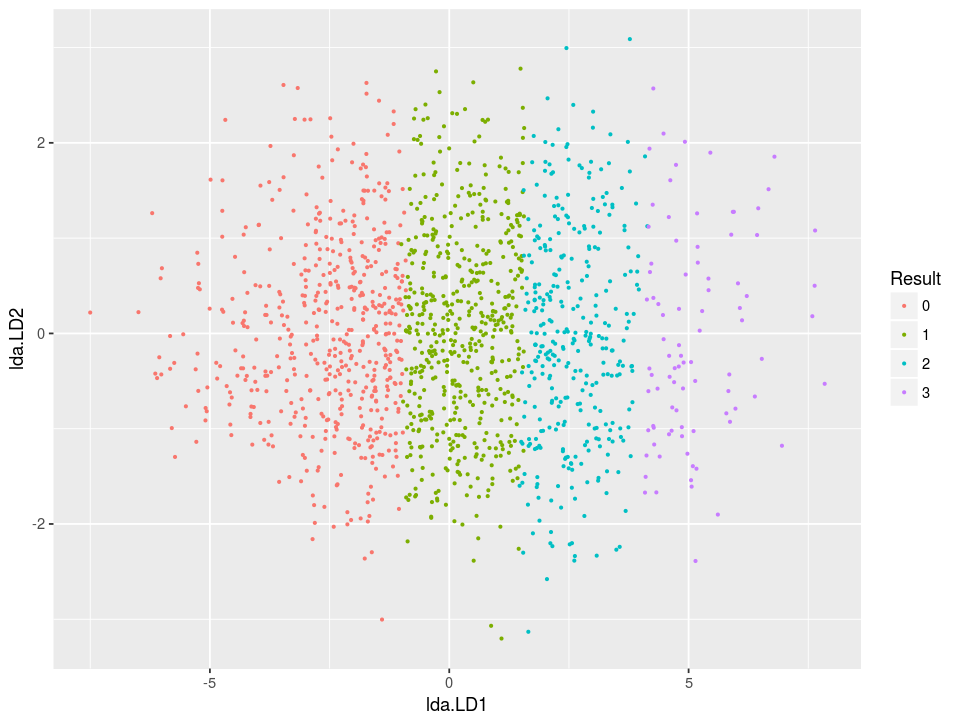

In [52]:
options(repr.plot.width=8, repr.plot.height=6)
dataset = data.frame(Result = ldaImputedDataCV$testing[[1]][,'Result'], lda = ldaPredict$x)
ggplot(dataset) + geom_point(aes(lda.LD1, lda.LD2, colour = Result), size = .5)

As expected there is excellent separation of the data along the x-axis which represents linear dsicriminant LD1. While we won't be using the LDA classifier as our chosen model it was useful to be able to visualise the data in two dimensions.

### Support Vector Machine Classification
A support vector is a vector that describes one data point in n-dimensional space (in our case eleven dimensional space for our ten attributes and one target variable). A support vector machine simply finds lines or in this case hyperplanes between the data points and finds the planes that do the best job of separating the data while maximimising the margin (distance between the hyperplane and the nearest data point). Although support vector machines can be converted to non-linear using different kernels we will be using the "vanila" implementation which finds linear hyperplanes.

We would expect excellent results as the main difference between logistic regression and support vector machines is the loss function, logtistic regression uses the a logistic loss function while SVM uses a hinge function. We can use the caret package to speed up our model building and automatically train the model using cross validation with ten folds. For the svm model we will also change the cost parameter.

In [53]:
svmGrid <- expand.grid(C = c(0.75, 1, 1.5, 2, 5, 10))
trctrl <- trainControl(method = "cv", number = 10, summaryFunction = multiClassSummary)

svmModel <- train(Result ~ ., data = imputedData, preProc = c("center","scale"), method = "svmLinear", trControl=trctrl, tuneGrid = svmGrid)
svmModel
#svmPredict <- predict(object = svmModel, newdata = imputedDataCV$testing[[1]])
#confusionMatrix(imputedDataCV$testing[[1]]$Result, svmPredict)

Support Vector Machines with Linear Kernel 

3000 samples
  10 predictors
   4 classes: '0', '1', '2', '3' 

Pre-processing: centered (10), scaled (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2699, 2700, 2700, 2701, 2700, 2701, ... 
Resampling results across tuning parameters:

  C      Accuracy   Kappa      Mean_F1    Mean_Sensitivity  Mean_Specificity
   0.75  0.9926655  0.9893654  0.9941033  0.9933262         0.9971347       
   1.00  0.9939989  0.9912984  0.9929077  0.9923760         0.9977845       
   1.50  0.9970022  0.9956601  0.9931669  0.9940116         0.9991072       
   2.00  0.9973355  0.9961423  0.9939735  0.9944022         0.9991965       
   5.00  0.9986689  0.9980758  0.9973495  0.9986087         0.9996032       
  10.00  0.9996678  0.9995195  0.9997685  0.9997685         0.9998705       
  Mean_Pos_Pred_Value  Mean_Neg_Pred_Value  Mean_Precision  Mean_Recall
  0.9950402            0.9974011            0.9950402       0.9933262  
  0.9937578  

Not surprisingly our accuracy approaches 1 for SVMs, similar to what was achieved with logistic regression. It is arguable which is the simpler model, SVM or logistic regression. This study (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2612652/) suggests that medical clinicians are more familiar with logistic regression and since the models are otherwise incredibly similar in complexity, computing time and performances we will reccomend the logistic regression model.

### Gradient Boosted Machines
Gradient boosted machines is a family of learning algorithms that use gradient boosting in order to improve their accuracy. Gradient boosting builds models consecutively, the first model make an attempt to fir the training data with a decision tree, the second model then tries to reconstruct the residual (close the gap between the prediction by the first model and the actual target value). Gradient descent is used to minimize loss when adding trees.

We'll use h2o to build both our Gradient Boosted Machine classifier and later our Neural Network Classifier. h2o is a java based packaged that runs in memory and can offer significant benefits both in terms of functionality and speed. Although for the relatively small data set we have we could build the models in standard R it is a good opportunity to develop some skills in h2o.

First of all let's initialize the h2o instance.

In [54]:
#h2o.shutdown()
h2o.init(nthreads=-1, min_mem_size = "12G")
h2o.removeAll() ## clean slate - just in case the cluster was already running

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 46 minutes 
    H2O cluster version:        3.14.0.3 
    H2O cluster version age:    29 days  
    H2O cluster name:           H2O_started_from_R_rstudio_ghg595 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   11.03 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.1 (2017-06-30) 

[1] 0


Now we need to import the data frame as a h2o object.

In [55]:
imputedData.hex <- as.h2o(imputedData)

  |======================================================================| 100%


Set the y (target) and x (predictor) variables.

In [56]:
y = 'Result'
x = names(imputedData)
x = x[-which(x==y)]

Let's try the gradient boosted model with the default settings and check the confusion matrix (accuracy).

In [57]:
gbmModel <- h2o.gbm(
  ## standard model parameters
  x = x, 
  y = y, 
  training_frame = imputedData.hex, 
  nfolds = 10)

h2o.confusionMatrix(h2o.performance(gbmModel, xval = TRUE))

  |======================================================================| 100%


,0,1,2,3,Error,Rate
0,943,138,1,0,0.1284658,"139 / 1,082"
1,130,880,69,1,0.1851852,"200 / 1,080"
2,0,227,405,10,0.3691589,237 / 642
3,0,1,137,58,0.7040816,138 / 196
Totals,1073,1246,612,69,0.2380000,"714 / 3,000"


It predicted 2270/3000 correct, or an approximate accuracy rate of 75%. We'll and improve it by setting up a search grid

<b>GBM Hyper Parameters</b><br>
The hyper paramters for an algorithm allow the algorithm to be tuned to find the best results. The main ones available to us in gradient boosted machines (in the implementation in h2o) are maximum depth and number of trees. Here we will search through a max_depth grid of 4, 6, 8, 12, 16 and 20 while allowing up to 10,000 trees to be built. We will add in an early stopping condition so that adiditonal trees are only built if it is having an effect on the error rate. In this case if the misclassification rate doesn't change by 1% over ten rounds then the algorithm will stop. We'll also introduce a learning rate annealing which lowers the learning rate each after each tree.

In [58]:
hyper_params = list( max_depth = c(4,6,8,12,16,20) )
grid <- h2o.grid(
  ## hyper parameters
  hyper_params = hyper_params,
  
  ## full Cartesian hyper-parameter search
  search_criteria = list(strategy = "Cartesian"),
  
  ## which algorithm to run
  algorithm="gbm",
  
  ## identifier for the grid, to later retrieve it
  grid_id="depth_grid",
  
  ## standard model parameters
  x = x, 
  y = y, 
  training_frame = imputedData.hex, 
  
  ## more trees is better if the learning rate is small enough 
  ## here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            
  
  ## smaller learning rate is better
  ## since we have learning_rate_annealing, we can afford to start with a bigger learning rate
  learn_rate = 0.05,                                                         
  
  ## learning rate annealing: learning_rate shrinks by 1% after every tree 
  ## (use 1.00 to disable, but then lower the learning_rate)
  learn_rate_annealing = 0.99,                                               
  
  ## fix a random number generator seed for reproducibility
  seed = 1234,                                                             
  
  ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 10,
  stopping_tolerance = 1e-2,
  stopping_metric = "misclassification", 
  
  ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10                                                
)

  |======================================================================| 100%


<b>Model Performance</b><br>
We'll sort the grid results by decreasing accuracy

In [59]:
sortedGrid <- h2o.getGrid("depth_grid", sort_by="accuracy", decreasing = TRUE)    
sortedGrid

H2O Grid Details

Grid ID: depth_grid 
Used hyper parameters: 
  -  max_depth 
Number of models: 6 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing accuracy
  max_depth          model_ids           accuracy
1        12 depth_grid_model_3                1.0
2        20 depth_grid_model_5                1.0
3         8 depth_grid_model_2                1.0
4        16 depth_grid_model_4                1.0
5         6 depth_grid_model_1 0.9983333333333333
6         4 depth_grid_model_0              0.946

Let's look at the error rate of the best model.

In [60]:
gbmModel <- h2o.getModel(sortedGrid@model_ids[[1]])
as.numeric(sortedGrid@summary_table$accuracy[1])

[1] 1

Just like our other models we have achieved 100% accuracy. A gbm model is significantly more complex than either the logistic regression or the SVM models already built, for linearly separable problems this algorithm is "over the top" in terms of power and fleixbility.

<b>Neural Network</b><br>
Neural networks mimic the way the brain works. Neural networks are made up of connected layers of neurons, the processing or decision making is largely dependent on the weights of the connections. Once again we'll use the h2o package to build the classifier.

Let's try and build a small network with mainly default settings, we'll limit the hidden layers to two layers with five neurons each, a rather small network really.

In [61]:
nnModel <- h2o.deeplearning(
  x = x,
  y = y,
  training_frame = imputedData.hex, 
  hidden = c(5,5),       ## default: 2 hidden layers with 200 neurons each
  epochs = 1000,
  nfolds = 10
)

  |======================================================================| 100%


<b>Model Performance</b><br>

In [62]:
as.numeric(nnModel@model$cross_validation_metrics_summary[1,'mean'])

[1] 0.9979755

Even a fairly basic neural netowrk does an excellenr job of classifying the data. This is not surprising, neural networks are very flexible and this one only has to manage to separate linearly separable data, something nearual networks can easily achieve. Again even though this model performs well it is much more complex than models that perform equally well and for that reason will not be reccomended as the final model.

## Conclusion and Final Model
As previously mentioned the logistic regression classification model is one of the simplest models available for linear classification and also one that medical clinicians are most familiar with. We'll build our final model using  logisitic regression using all of the available training data for use in classifying future data sets.

In [63]:
# build a matrix out of all the imputed data
train <- imputedData
train.data = train[, -which(names(imputedData)  == 'Result')]
train.label = train[, 'Result']
train_x <- as.matrix(train.data)
train_y <- train.label

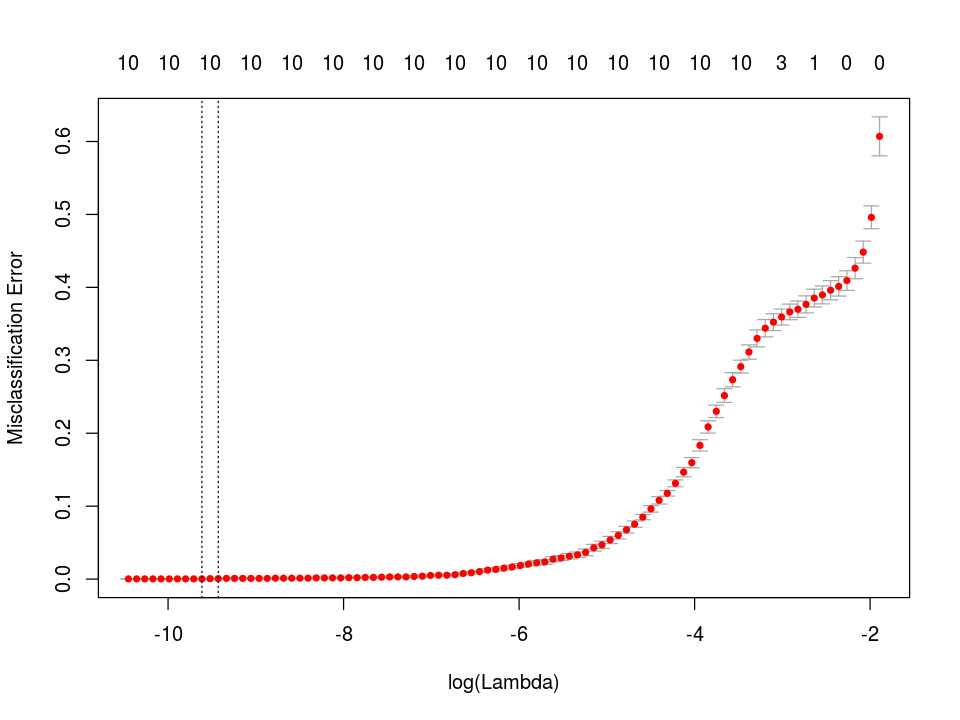

In [64]:
# find the best cv value and plot the misclassification vs log(lamda) rate
options(warn=-1)
finalModel <- cv.glmnet(train_x, train_y, family='multinomial', alpha=1, parallel=TRUE, standardize=TRUE, type.measure='class')
plot(finalModel)

From the log(lambda) vs misclassification error plot we can expect excellet results from our finalModel.

In [65]:
finalModel

$lambda
 [1] 1.507027e-01 1.373147e-01 1.251161e-01 1.140011e-01 1.038736e-01
 [6] 9.464571e-02 8.623765e-02 7.857653e-02 7.159601e-02 6.523562e-02
[11] 5.944027e-02 5.415976e-02 4.934835e-02 4.496438e-02 4.096987e-02
[16] 3.733022e-02 3.401391e-02 3.099220e-02 2.823894e-02 2.573027e-02
[21] 2.344447e-02 2.136172e-02 1.946401e-02 1.773488e-02 1.615936e-02
[26] 1.472381e-02 1.341579e-02 1.222396e-02 1.113802e-02 1.014855e-02
[31] 9.246980e-03 8.425504e-03 7.677005e-03 6.995001e-03 6.373585e-03
[36] 5.807373e-03 5.291462e-03 4.821383e-03 4.393065e-03 4.002797e-03
[41] 3.647200e-03 3.323192e-03 3.027969e-03 2.758973e-03 2.513873e-03
[46] 2.290548e-03 2.087062e-03 1.901653e-03 1.732715e-03 1.578786e-03
[51] 1.438531e-03 1.310736e-03 1.194293e-03 1.088196e-03 9.915234e-04
[56] 9.034392e-04 8.231801e-04 7.500511e-04 6.834186e-04 6.227056e-04
[61] 5.673861e-04 5.169811e-04 4.710539e-04 4.292068e-04 3.910773e-04
[66] 3.563350e-04 3.246792e-04 2.958356e-04 2.695544e-04 2.456079e-04
[71] 2.23788

In [66]:
# for predictions provide data frame of predictors
#test.data <- 
#predictorMatrix <- as.matrix(test.data)
#finalModel.Predictions <- predict(finalModel, s = finalModel$lambda.min, predictorMatrix, type='class')

### References
http://web.maths.unsw.edu.au/~dwarton/missingDataLab.html <br>
https://machinelearningmastery.com/linear-discriminant-analysis-for-machine-learning/ <br>
http://sebastianraschka.com/Articles/2014_python_lda.html <br>
https://rstudio-pubs-static.s3.amazonaws.com/35817_2552e05f1d4e4db8ba87b334101a43da.html <br>
https://blog.h2o.ai/2016/06/h2o-gbm-tuning-tutorial-for-r/ <br>
https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/ <br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2612652/ <br>
http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/ <br>
https://en.wikipedia.org/wiki/Artificial_neural_network <br>
http://pages.cs.wisc.edu/~bolo/shipyard/neural/local.html <br>